# Precipitation Nowcasting using Neural Networks

In this exercise, you are going to build a set of deep learning models on a real world task using PyTorch. PyTorch is an open source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR).

## Setting up to use the gpu  

Before we start, we need to change the environment of Colab to use GPU. Do so by:

Runtime -> Change runtime type -> Hardware accelerator -> GPU

## Deep Neural Networks with PyTorch ##

To complete this exercise, you will need to build deep learning models for precipitation nowcasting. You will build a subset of the models shown below:
- Fully Connected (Feedforward) Neural Network
- A Feedforward network with dropout
- A convolution neural network model

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for PyTorch in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

This notebook assumes you have already installed PyTorch with python3 and had GPU enabled. If you run this exercise on Colab you are all set.

## Precipitation Nowcasting ##

Precipitation nowcasting is the the task of predicting the amount of rainfall in a certain region given some kind of sensor data.  The term nowcasting refers to tasks that try to predict the current or near future conditions (within 6 hours).

You will be given satellite images in 3 different bands covering a 5 by 5 region from different parts of Thailand. In other words, your input will be a 5x5x3 image. Your task is to predict the amount of rainfall in the center pixel. You will first do the prediction using just a simple fully-connected neural network that view each pixel as different input features.

Since the your input is basically an image, we will then view the input as an image and apply CNN to do the prediction. Finally, we can also add a time component since weather prediction can benefit greatly using previous time frames. Each data point actually contain 5 time steps, so each input data point has a size of 5x5x5x3 (time x height x width x channel), and the output data has a size of 5 (time). You will use this time information when you work with RNNs.

Finally, we would like to thank the Thai Meteorological Department for providing the data for this assignment.

In [1]:
!nvidia-smi

Thu Apr 17 07:28:40 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.25                 Driver Version: 536.25       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P5              23W /  35W |      0MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# For summarizing and visualizing models
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\miniconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Weights and Biases

[Weights and Biases](https://docs.wandb.ai/company) (wandb) is an experiment tracking tool for machine learning. It can log and visualize experiments in real time. It supports many popular ML frameworks, and obviously PyTorch is one of them. In this notebook you will learn how to log general metrics like losses, parameter distributions, and gradient distribution with wandb.

To install wandb, run the cell below

## Weights and Biases

[Weights and Biases](https://docs.wandb.ai/company) (wandb) is an experiment tracking tool for machine learning. It can log and visualize experiments in real time. It supports many popular ML frameworks, and obviously PyTorch is one of them. In this notebook you will learn how to log general metrics like losses, parameter distributions, and gradient distribution with wandb.

To install wandb, run the cell below

In [3]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\miniconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setup

1. Register [Wandb account](https://wandb.ai/login?signup=true) (and confirm your email)

2. `wandb login` and copy paste the API key when prompt

In [4]:
!wandb login

wandb: Currently logged in as: taihenc (taihenc-chulalonkorn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

torch.__version__ # 2.6.0+cu124

'2.3.1+cpu'

## Loading the data

You can load the dataset from huggingface hub by running the following.

In [6]:
!pip install huggingface_hub

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\miniconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="ecitslos/HWnowcastingdata", filename="nowcastingHWdataset.tar.gz", repo_type="dataset", local_dir=".")

'nowcastingHWdataset.tar.gz'

In [8]:
!tar -xvf './nowcastingHWdataset.tar.gz'

dataset/features-m10.pk
dataset/features-m6.pk
dataset/features-m7.pk
dataset/features-m8.pk
dataset/features-m9.pk
dataset/labels-m10.pk
dataset/labels-m6.pk
dataset/labels-m7.pk
dataset/labels-m8.pk
dataset/labels-m9.pk


# Data Explanation #

The data is an hourly measurement of water vapor in the atmosphere, and two infrared measurements of cloud imagery on a latitude-longitude coordinate. Each measurement is illustrated below as an image. These three features are included as different channels in your input data.

<img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/wvapor.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud1.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud2.png" width="200">

We also provide the hourly precipitation (rainfall) records in the month of June, July, August, September, and October from weather stations spreaded around the country. A 5x5 grid around each weather station at a particular time will be paired with the precipitation recorded at the corresponding station as input and output data. Finally, five adjacent timesteps are stacked into one sequence.

The month of June-August are provided as training data, while the months of September and October are used as validation and test sets, respectively.


# Reading data

In [9]:
def read_data(months, data_dir='dataset'):
    features = np.array([], dtype=np.float32).reshape(0,5,5,5,3)
    labels = np.array([], dtype=np.float32).reshape(0,5)
    for m in months:
        filename = 'features-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            features_temp = pickle.load(file)
        features = np.concatenate((features, features_temp), axis=0)

        filename = 'labels-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            labels_temp = pickle.load(file)
        labels = np.concatenate((labels, labels_temp), axis=0)

    return features, labels

In [10]:
# use data from month 6,7,8 as training set
x_train, y_train = read_data(months=[6,7,8])

# use data from month 9 as validation set
x_val, y_val = read_data(months=[9])

# use data from month 10 as test set
x_test, y_test = read_data(months=[10])

print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


**features**
- dim 0: number of entries
- dim 1: number of time-steps in ascending order
- dim 2,3: a 5x5 grid around rain-measued station
- dim 4: water vapor and two cloud imagenaries

**labels**
- dim 0: number of entries
- dim 1: number of precipitation for each time-step

# Three-Layer Feedforward Neural Networks

In [11]:
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_ff(x_train, y_train, x_val, y_val):
    x_train_ff = x_train.reshape((-1, 5*5*3))
    y_train_ff = y_train.reshape((-1, 1))
    x_val_ff = x_val.reshape((-1, 5*5*3))
    y_val_ff = y_val.reshape((-1, 1))
    x_test_ff = x_test.reshape((-1, 5*5*3))
    y_test_ff = y_test.reshape((-1, 1))

    return x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff

x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff = preprocess_for_ff(x_train, y_train, x_val, y_val)
print(x_train_ff.shape, y_train_ff.shape)
print(x_val_ff.shape, y_val_ff.shape)
print(x_test_ff.shape, y_test_ff.shape)

(1147740, 75) (1147740, 1)
(464195, 75) (464195, 1)
(558575, 75) (558575, 1)


### TODO#1

Explain each line of code in the function preprocess_for_ff()

**Ans:**

It reshape features to demension (N, 5*5*3) and labels to dimension (N, 1).

## Dataset

To prepare a DataLoader in order to feed data into the model, we need to create a `torch.utils.data.Dataset` object first. (Learn more about it [here](https://pytorch.org/docs/stable/data.html#map-style-datasets))

Dataset is a simple class that the DataLoader will get data from, most of its functionality comes from `__getitem__(self, index)` method, which will return a single data point (both input and label). In real world scenarios the method can do some other stuffs such as

1. Load images

If your input (x) are images. Oftentimes you won't be able to fit all the training images into your RAM. Thus, you should pass an array (or list) of image path into the dataloader, and the `__getitem__` will be the one who dynamically loads the actual image from the harddisk for you.

2. Data Normalization

Data normalization helps improve stability of training. Unnormalized data can cause gradients to explode. There are many variants of normalization, but in this notebook we will use either minmax or z-score (std) normalization. Read [this](https://developers.google.com/machine-learning/data-prep/transform/normalization) (or google) if you wish to learn more about data normalization.

3. Data Augmentation

In computer vision, you might want to apply small changes to the images you use in training (adjust brightness, contrast, rotation) so that the model will generalize better on unseen data. There are two kinds of augmentation: static and dynamic. Static augmentation will augment images and save to disk as a new dataset. On the other hand, rather than applying the change initially and use the same change on each image every epoch, dynamic augmentation will augment each data differently for each epoch. Note that augmentation is usually done on the CPU and you might be bounded by the CPU instead. PyTorch has a dedicated [documentation about data augmentation](https://pytorch.org/vision/master/transforms.html) if you want to know more.

In [12]:
class RainfallDatasetFF(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [13]:
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

In [14]:
normalizer = normalizer_std(x_train_ff) # We will normalize everything based on x_train

train_dataset = RainfallDatasetFF(x_train_ff, y_train_ff, normalizer)
val_dataset = RainfallDatasetFF(x_val_ff, y_val_ff, normalizer)
test_dataset = RainfallDatasetFF(x_test_ff, y_test_ff, normalizer)

(1147740, 75)
(1147740, 1)
(464195, 75)
(464195, 1)
(558575, 75)
(558575, 1)


## DataLoader

DataLoader feeds data from our dataset into the model. We can freely customize batch size, data shuffle for each data split, and much more with DataLoader class. If you're curious about what can you do with PyTorch's DataLoader, you can check [this documentation](https://pytorch.org/docs/stable/data.html)

In [88]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

## Loss Function

PyTorch has many loss functions readily available for use. We can also write our own custom loss function as well. But for now, we will use [PyTorch's built-in mean squared error loss ](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

In [16]:
loss_fn = nn.MSELoss()

### TODO#2

Why is the loss MSE?

**Ans:**

The loss is MSE because the output is a regression problem. The model will predict the amount of rainfall in the center pixel, and we want to minimize the difference between the predicted and actual values.

## Device

Unlike Tensorflow/Keras, PyTorch allows user to freely put any Tensor or objects (loss functions, models, optimizers, etc.) in CPU or GPU. By default, all objects created will be in CPU. In order to use GPU we will have to supply `device = torch.device("cuda")` into the objects to move it to GPU. You will usually see the syntax like `object.to(device)` for moving CPU object to GPU, or `o = Object(..., device=device)` to create the object in the GPU.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

Below, the code for creating a 3-layers fully connected neural network in PyTorch is provided. Run the code and make sure you understand what you are doing. Then, report the results.

In [18]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = F.relu(self.ff2(hd1))
        y = F.relu(self.ff3(hd2))
        y = self.out(y)
        return y.reshape(-1, 1)

### TODO#3

What is the activation function in the final dense layer? and why? Do you think there is a better activation function for the final layer?

**Ans:**

The activation function in the final dense layer is ReLU. it is good because the amount of rainfall is alwats positive. But we can still use other activation functions such as sigmoid to limit the output to a certain range. eg. from 0 to 100mm

In [19]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

In [20]:
from torchinfo import summary
summary(model_ff, input_size=(1024, 75))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN                            [1024, 1]                 --
├─Linear: 1-1                            [1024, 200]               15,200
├─Linear: 1-2                            [1024, 200]               40,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 95,801
Trainable params: 95,801
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 98.10
Input size (MB): 0.31
Forward/backward pass size (MB): 4.92
Params size (MB): 0.38
Estimated Total Size (MB): 5.61

### TODO#4

Explain why the first linear layer has number of parameters = 15200

**Ans:**

because we have input of 5x5x3 = 75 with 200 neurons so the number of parameters is 76*200 = 15200
76 is from SUM(wi * xi) + b

# Training

In [21]:
train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-2025',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: taihenc (taihenc-chulalonkorn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9259
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6583
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9201
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6591
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9202
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6614
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9207
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6572
Saving new best model..
Training epoch 5...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9205
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6589
Training epoch 6...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9222
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6585
Training epoch 7...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9234
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6607
Training epoch 8...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9233
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6611
Training epoch 9...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9232
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6629
Training epoch 10...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9236
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6607


lr,███████▁▁▁
train_loss,█▁▁▂▂▄▅▅▅▅
val_loss,▂▃▆▁▃▃▅▆█▅
lr,0.002
train_loss,1.92358
val_loss,1.66071


Finished Training


### TODO#5

Plot loss and val_loss as a function of epochs.

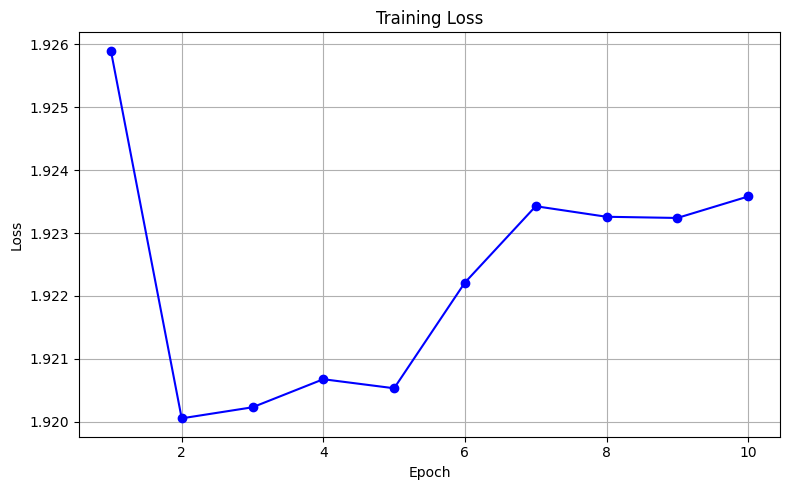

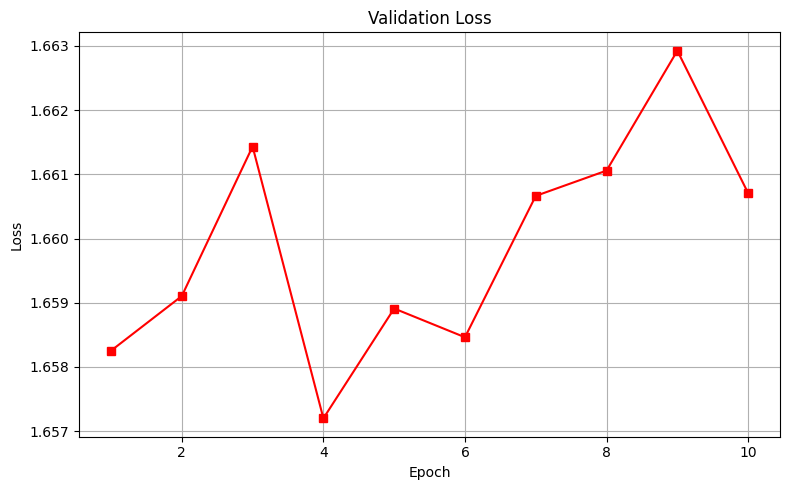

In [45]:
n = list(range(1, len(train_losses)+1))
# plot

plt.figure(figsize=(8, 5))
plt.plot(n, train_losses, label='Train Loss', marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(n, val_losses, label='Validation Loss', marker='s', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

### TODO#6

When does the model start to overfit?

**Ans:**

for evaluation 3 loss is drop so much on training set but increase on validation set acording to the graph. we may consider that a bit overfitting. But as we see the graph raising again then we can say that it not completely overfitting yet. maybe if we run more epochs it will show the sign of overfitting.

### TODO#7

Plot the learning rate as a function of the epochs.

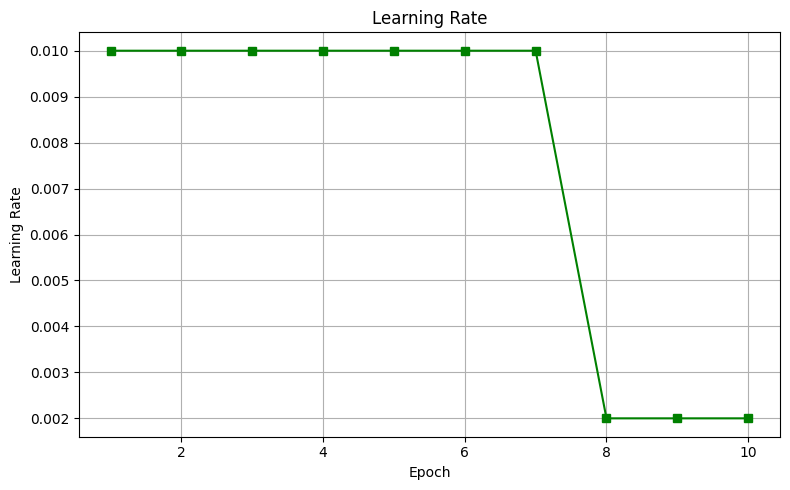

In [46]:
plt.figure(figsize=(8, 5))
plt.plot(n, learning_rates, label='Learning Rate', marker='s', color='green')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

### TODO#8

What makes the learning rate change?
(hint: try to understand the scheduler [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html))


**Ans:**

because we set the scheduler to be min mode with patience 2 and factor 0.2. this means if the validation loss does not decrease for 2 epochs, the learning rate will be reduced by a factor of 0.2. as we can se for 6-7 epochs is not decreasing so the learning rate is reduced to by factor of 0.2 so it drop to 0.0002

# Load Model

Use the code snippet below to load the model you just trained

In [49]:
checkpoint = torch.load('model_ff.pth.tar')
loaded_model = FeedForwardNN(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
print(f"Loaded epoch {checkpoint['epoch']} model")

Loaded epoch 3 model


# A more complex scheduling

The scheduler can be very complicated and you can write your own heuristic for it.

### TODO#9

Implement a custom learning rate scheduler that behaves like the following graph.

You might want to learn how to use [PyTorch's built-in learning rate schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) in order to build your own.

Learning rate should be function of epoch.

![](./graph.png)

In [50]:
# Implement scheduler here
from torch.optim.lr_scheduler import _LRScheduler

class MyScheduler(_LRScheduler):
    def __init__(self, optimizer: torch.optim.Optimizer):
        self.lr_by_epoch = {
            0: 0.0001,
            1: 0.0004,
            2: 0.0007,
            3: 0.001,
            4: 0.0008,
            5: 0.0006,
            6: 0.0005,
            7: 0.0010,
            8: 0.0003,
            9: 0.0001
        }
        super().__init__(optimizer)


    def get_lr(self):
        # Use specified LR if epoch is in mapping, otherwise keep the current LR
        return [
            self.lr_by_epoch.get(self.last_epoch, group['lr'])
            for group in self.optimizer.param_groups
        ]
      
    def step(self, epoch=None):
        """Advance to next epoch and update learning rate."""
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [51]:
# Now train with your scheduler
# my_scheduler = MyScheduler(...)
my_scheduler = MyScheduler(optimizer)

train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-2025',
    name='custom-lr',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        my_scheduler.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        my_scheduler.step(epoch)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': my_scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

Training epoch 1...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9236
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6611
Saving new best model..
Training epoch 2...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9236
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6613
Training epoch 3...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9232
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6612
Training epoch 4...
Current LR: 0.0007


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9237
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6611
Saving new best model..
Training epoch 5...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9233
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6610
Saving new best model..
Training epoch 6...
Current LR: 0.0008


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9232
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6612
Training epoch 7...
Current LR: 0.0006


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9236
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6612
Training epoch 8...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9232
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6611
Training epoch 9...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9233
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6611
Training epoch 10...
Current LR: 0.0003


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9231
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6610


lr,▁▁▃▆█▆▅▄█▃
train_loss,▆▇▂█▃▃▆▂▃▁
val_loss,▄█▆▃▁▆▅▃▄▂
lr,0.0003
train_loss,1.92311
val_loss,1.66102


Finished Training


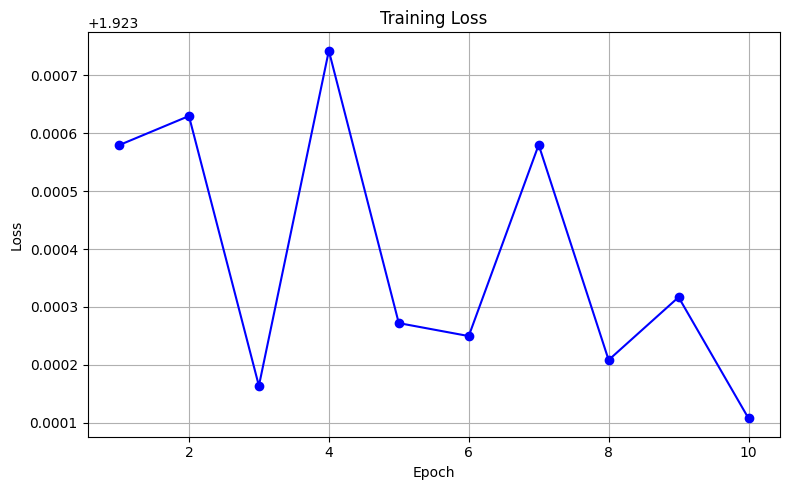

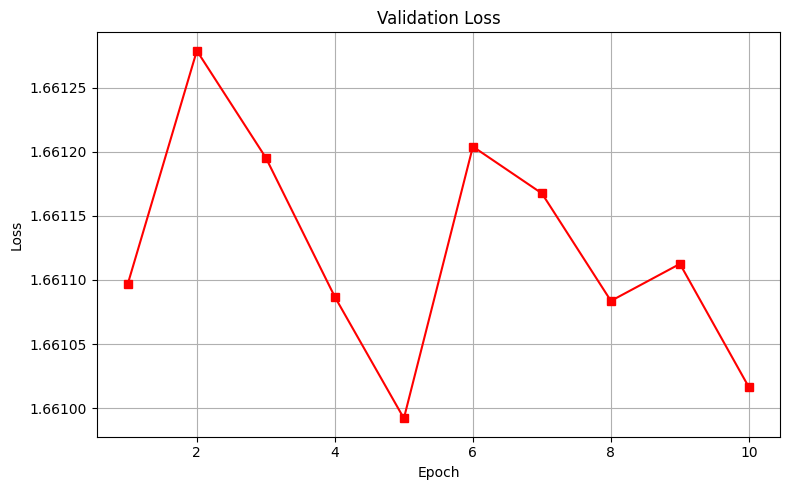

In [52]:
n = list(range(1, len(train_losses)+1))
# plot

plt.figure(figsize=(8, 5))
plt.plot(n, train_losses, label='Train Loss', marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(n, val_losses, label='Validation Loss', marker='s', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

# [Optional] Wandb #

You should now have a project in wandb with the name `precipitation-nowcasting`, which you should see the latest run you just finished inside the project. If you look into the run, you should be able to see plots of learning rate, train loss, val loss in the `Charts` section. Below it should be `Gradients` and `Parameters` section.

# Wandb Observation #

### Optional TODO#1

Write your own interpretation of the logs from this example. A simple sentence or two for each section is sufficient.

**Your answer:**

# Evaluation

In [61]:
################################################################################
# TODO#10:                                                                     #
# Write a function to evaluate your model. Your function must predicts         #
# using the input model and return mean square error of the model.             #
#                                                                              #
# Hint: Read how to use PyTorch's MSE Loss                                     #
# https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def evaluate(data_loader, model):
    """
    Evaluate model on validation data given by data_loader
    """
    # write code here
    wandb.init(project='precipitation-nowcasting-2025', name='evaluate', reinit=True)
    
    model.eval()
    mse_loss = nn.MSELoss()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, y_true in tqdm(data_loader):
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            outputs = model(inputs)
            loss = mse_loss(outputs, y_true)

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

    mse = total_loss / total_samples
    wandb.finish()

    return torch.tensor(mse)

In [54]:
# We will use majority rule as a baseline.
def majority_baseline(label_set):
    unique, counts = np.unique(label_set, return_counts=True)
    majority = unique[np.argmax(counts)]
    baseline = 0
    label_set = label_set.reshape(-1,1)
    for r in label_set:
        baseline += (majority - r) ** 2 / len(label_set)
    return baseline

In [103]:
print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))
print('test', majority_baseline(y_test))

baseline
train [1.94397725]
validate [1.6746546]
test [1.16865877]


In [104]:
print('FF-model')
print('train', evaluate(train_loader, model_ff).item())
print('validate', evaluate(val_loader, model_ff).item())
print('test', evaluate(test_loader, model_ff).item())

FF-model


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.9233144521713257


  0%|          | 0/453 [00:00<?, ?it/s]

validate 1.6646380424499512


  0%|          | 0/546 [00:00<?, ?it/s]

test 1.1672968864440918


# Dropout #

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout (dropout rate of 20%) to the model, run, and report the result again.

To access PyTorch's dropout, use `nn.Dropout`. Read more about PyTorch's built-in Dropout layer [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [63]:
################################################################################
# TODO#11:                                                                     #
# Write a feedforward model with dropout                                       #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200, dropout_rate=0.2):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd1 = self.dropout(hd1)

        hd2 = F.relu(self.ff2(hd1))
        hd2 = self.dropout(hd2)

        y = F.relu(self.ff3(hd2))
        y = self.dropout(y)

        y = self.out(y)
        return y.reshape(-1, 1)

In [64]:
################################################################################
# TODO#12:                                                                     #
# Complete the code to train your dropout model                                #
################################################################################
print('start training ff dropout')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
model_ff_d = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff_d = model_ff_d.to(device)
optimizer = torch.optim.Adam(model_ff_d.parameters(), lr=config['lr'])
scheduler = MyScheduler(optimizer)

# train
train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-2025',
    name='model_with_dropout',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff_d, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff_d.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff_d(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        scheduler.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff_d.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff_d(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(epoch)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff_d.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff_d.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')


start training ff dropout


Training epoch 1...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9199
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6560
Saving new best model..
Training epoch 2...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9186
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6557
Saving new best model..
Training epoch 3...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9183
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6567
Training epoch 4...
Current LR: 0.0007


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9182
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6562
Training epoch 5...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9183
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6554
Saving new best model..
Training epoch 6...
Current LR: 0.0008


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9182
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6557
Training epoch 7...
Current LR: 0.0006


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9179
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6559
Training epoch 8...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9177
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6557
Training epoch 9...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9176
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6553
Saving new best model..
Training epoch 10...
Current LR: 0.0003


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9178
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6572


lr,▁▁▃▆█▆▅▄█▃
train_loss,█▄▃▃▃▃▂▁▁▂
val_loss,▄▂▆▄▁▂▃▂▁█
lr,0.0003
train_loss,1.9178
val_loss,1.6572


Finished Training


### TODO#13

Plot the losses and MSE of the training and validation as before. Evaluate the dropout model's performance

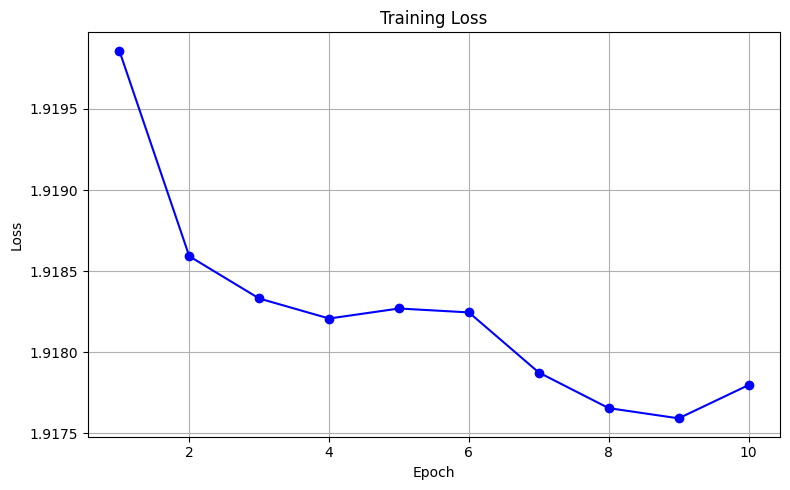

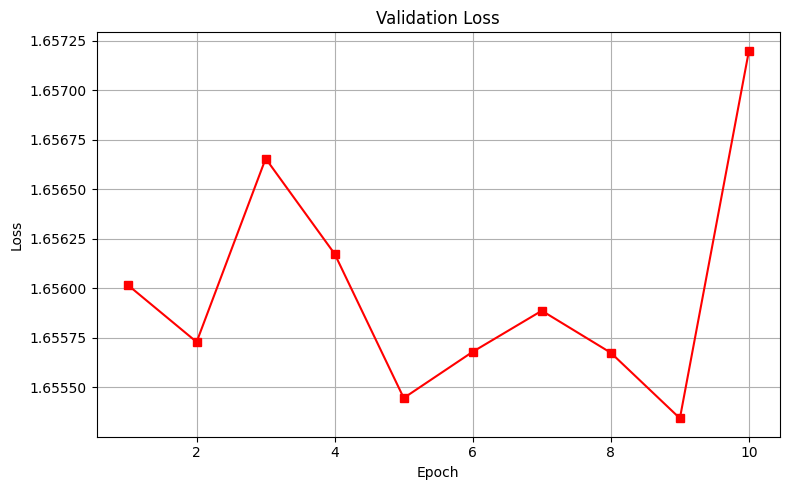

In [66]:
# Plot here
n = list(range(1, len(train_losses)+1))
# plot
plt.figure(figsize=(8, 5))
plt.plot(n, train_losses, label='Train Loss', marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(n, val_losses, label='Validation Loss', marker='s', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


In [102]:
# Evaluate
print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))
print('test', majority_baseline(y_test))
print('FF-dropout-model')
print('train', evaluate(train_loader, model_ff_d).item())
print('validate', evaluate(val_loader, model_ff_d).item())
print('test', evaluate(test_loader, model_ff_d).item())

baseline
train [1.94397725]
validate [1.6746546]
test [1.16865877]
FF-dropout-model


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.9175843000411987


  0%|          | 0/453 [00:00<?, ?it/s]

validate 1.6607768535614014


  0%|          | 0/546 [00:00<?, ?it/s]

test 1.1624215841293335


# Convolution Neural Networks
Now let's try to incorporate the grid sturcture to your model. Instead of passing in vectors, we are going to pass in the 5x5 grid into the model (5lat x 5long x 3channel). You are going to implement you own 2d-convolution neural networks with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Conv2DNN                                 --                        --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
==========================================================================================
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
```
These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         

Hint: You should read PyTorch documentation to see the list of available layers and options you can use.                         

In [69]:
################################################################################
# TODO#15:                                                                     #
# Write a PyTorch convolutional neural network model.                          #
# You might want to use the layer torch.flatten somewhere                      #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class Conv2DNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(Conv2DNN, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=3)
        self.fc1 = nn.Linear(200 * 3 * 3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.conv(x))
        hd1 = hd1.reshape(hd1.size(0), -1)
        hd2 = F.relu(self.fc1(hd1))
        hd3 = F.relu(self.fc2(hd2))
        y = F.relu(self.fc2(hd3))
        y = self.out(y)
        return y.reshape(-1, 1)


In [72]:
################################################################################
# TODO#16:                                                                     #
# Complete the code to train your cnn model                                    #
################################################################################
print('start training conv2d')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
model_conv2d = Conv2DNN(hidden_size=config['hidden_size'])
model_conv2d = model_conv2d.to(device)
optimizer = torch.optim.Adam(model_conv2d.parameters(), lr=config['lr'])
scheduler = MyScheduler(optimizer)

train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-2025',
    name='model_conv2d_nn',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_conv2d, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_conv2d.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.view(-1, 5, 5, 3)
        inputs = inputs.permute(0, 3, 1, 2)
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_conv2d(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        scheduler.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_conv2d.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.view(-1, 5, 5, 3)
            inputs = inputs.permute(0, 3, 1, 2)
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_conv2d(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(epoch)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_conv2d.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_conv2d.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

start training conv2d


lr,▁▁▃▆█▆▅▄
train_loss,█▄▃▃▂▂▂▁
val_loss,▂▁▄▅▄▁▂█
lr,0.0005
train_loss,1.91722
val_loss,1.6565


Training epoch 1...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9186
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6558
Saving new best model..
Training epoch 2...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9180
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6561
Training epoch 3...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9179
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6559
Training epoch 4...
Current LR: 0.0007


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9176
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6561
Training epoch 5...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9175
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6555
Saving new best model..
Training epoch 6...
Current LR: 0.0008


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9174
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6563
Training epoch 7...
Current LR: 0.0006


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9171
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6555
Training epoch 8...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9171
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6566
Training epoch 9...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9169
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6555
Saving new best model..
Training epoch 10...
Current LR: 0.0003


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9168
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6582


lr,▁▁▃▆█▆▅▄█▃
train_loss,█▆▅▄▄▃▂▂▂▁
val_loss,▂▃▂▃▁▃▁▄▁█
lr,0.0003
train_loss,1.91675
val_loss,1.65821


Finished Training


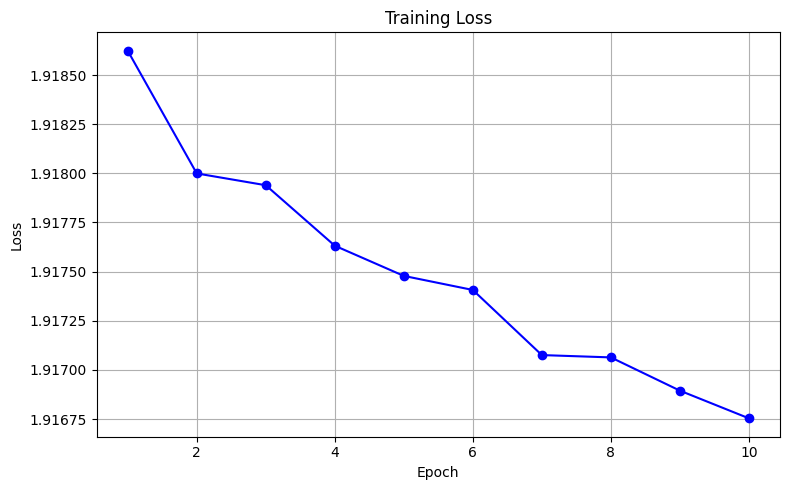

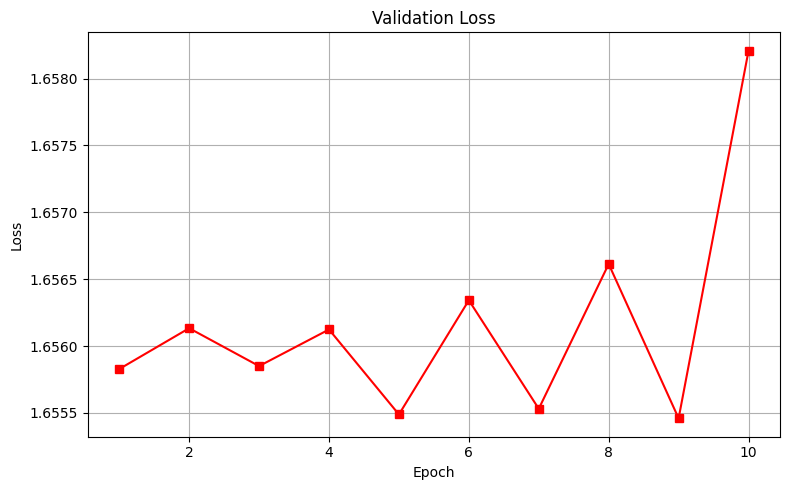

In [73]:
# Plot losses
n = list(range(1, len(train_losses)+1))
# plot
plt.figure(figsize=(8, 5))
plt.plot(n, train_losses, label='Train Loss', marker='o', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5)) 
plt.plot(n, val_losses, label='Validation Loss', marker='s', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
def evaluate_conv2d(data_loader, model):
    """
    Evaluate model on validation data given by data_loader
    """
    # write code here
    wandb.init(project='precipitation-nowcasting-2025', name='evaluation', reinit=True)

    model.eval()  # Set to eval mode (disables dropout, etc.)
    mse_loss = nn.MSELoss()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, y_true in tqdm(data_loader):
            inputs = inputs.view(-1, 5, 5, 3)
            inputs = inputs.permute(0, 3, 1, 2)
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            outputs = model(inputs)
            loss = mse_loss(outputs, y_true)

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

    mse = total_loss / total_samples
    wandb.finish()
    return torch.tensor(mse)  # or just return mse if you're fine with float

In [75]:
# Evaluate
print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))
print('Conv2D-model')
print('train',  evaluate_conv2d(train_loader, model_conv2d).item())
print('validate', evaluate_conv2d(val_loader, model_conv2d).item())

baseline
train [1.94397725]
validate [1.6746546]
Conv2D-model


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.9175564050674438


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.6606420278549194


# Final Section
# PyTorch playground

Now, train the best model you can do for this task. You can use any model structure and function available.    
Remember that trainig time increases with the complexity of the model. You might find printing computation graphs helpful in debugging complicated models.    
Your model should be better than your models in the previous sections

Some ideas:

- Tune the hyperparameters
- Change the model architecture
- Use or ignore the time sequence information

You should tune your model on training and validation set.    
**The test set should be used only for the last evaluation.**

In [86]:
# Prep data as you see fit
def prep_data(x):
  x = x.permute(0, 1, 4, 2, 3)

In [105]:
################################################################################
# TODO#17                                                                      #
# Write a function that returns your best PyTorch model. You can use anything  #
# you want. The goal here is to create the best model you can think of.        #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class TimeSequenceDataset(Dataset):
    def __init__(self, features, labels, normalizer=None):
        """
        features: shape [N, 5, 5, 5, 3] - [samples, time, height, width, channels]
        labels: shape [N, 5] - [samples, time]
        """
        self.features = features.astype(np.float32)
        self.labels = labels.astype(np.float32)
        self.normalizer = normalizer
        
    def __getitem__(self, index):
        x = self.features[index]  # [5, 5, 5, 3]
        y = self.labels[index]    # [5]
        
        # Normalize features if needed
        if self.normalizer:
            # Apply normalization across spatial dimensions but preserve temporal dimension
            original_shape = x.shape
            x = x.reshape(-1, original_shape[-1])  # Flatten spatial dims
            x = self.normalizer.transform(x)
            x = x.reshape(original_shape)
        
        # Return the middle frame's rainfall as target
        return x, y[2:3]  # Target is the middle frame
        
    def __len__(self):
        return len(self.features)

# Improved model architecture
class ImprovedRainfallModel(nn.Module):
    def __init__(self, hidden_size=128):
        super(ImprovedRainfallModel, self).__init__()
        
        # CNN for spatial features
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Reduce spatial dimensions
        )
        
        # Calculate CNN output size
        cnn_output_size = 64 * 2 * 2  # channels * height/2 * width/2
        
        # LSTM for temporal features
        self.lstm = nn.LSTM(
            input_size=cnn_output_size,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=True
        )
        
        # Output layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),  # *2 for bidirectional
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        # x shape: [batch, time, channels, height, width]
        batch_size, time_steps, channels, height, width = x.shape
        
        # Process each time step with CNN
        cnn_outputs = []
        for t in range(time_steps):
            # Get current time step
            x_t = x[:, t]  # [batch, channels, height, width]
            
            # Apply CNN
            cnn_out = self.cnn(x_t)  # [batch, channels, height/2, width/2]
            
            # Flatten spatial dimensions
            cnn_out = cnn_out.reshape(batch_size, -1)  # [batch, features]
            
            cnn_outputs.append(cnn_out)
        
        # Stack time steps
        cnn_outputs = torch.stack(cnn_outputs, dim=1)  # [batch, time, features]
        
        # Apply LSTM
        lstm_out, _ = self.lstm(cnn_outputs)  # [batch, time, hidden*2]
        
        # Use the final time step's output
        final_hidden = lstm_out[:, -1]  # [batch, hidden*2]
        
        # Output layer
        output = self.fc(final_hidden)  # [batch, 1]
        
        return output

In [106]:
# Create datasets with the correct time sequence handling
# First normalize the data correctly
def normalize_spatial_data(features):
    """Normalize spatial dimensions while preserving temporal structure."""
    # Reshape to flatten spatial dims but keep time and channels separate
    original_shape = features.shape
    features_flat = features.reshape(-1, original_shape[-1])
    
    # Create and fit normalizer
    scaler = preprocessing.StandardScaler().fit(features_flat)
    
    return scaler

# Create normalized datasets
spatial_normalizer = normalize_spatial_data(x_train.reshape(-1, 3))

# Create sequence datasets
train_seq_dataset = TimeSequenceDataset(x_train, y_train, spatial_normalizer)
val_seq_dataset = TimeSequenceDataset(x_val, y_val, spatial_normalizer)
test_seq_dataset = TimeSequenceDataset(x_test, y_test, spatial_normalizer)

# Create data loaders
train_seq_loader = DataLoader(train_seq_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_seq_loader = DataLoader(val_seq_dataset, batch_size=64, shuffle=False, pin_memory=True)
test_seq_loader = DataLoader(test_seq_dataset, batch_size=64, shuffle=False, pin_memory=True)

# Initialize the model and optimizer
model_best = ImprovedRainfallModel().to(device)
optimizer = torch.optim.Adam(model_best.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=2, min_lr=1e-5
)
criterion = nn.MSELoss()

# Training loop
num_epochs = 15
train_losses = []
val_losses = []

# Initialize wandb
wandb.init(
    project='precipitation-nowcasting-2025',
    name='improved-model',
    config={
        'architecture': 'cnn-bilstm',
        'lr': 0.001,
        'epochs': num_epochs,
    },
)

# Log model architecture
wandb.watch(model_best, log='all')

for epoch in range(num_epochs):
    # Training
    model_best.train()
    train_loss = []
    
    for inputs, targets in tqdm(train_seq_loader):
        # Move to device
        inputs = inputs.permute(0, 1, 4, 2, 3).to(device)  # [B, T, C, H, W]
        targets = targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model_best(inputs)
        
        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Track loss
        train_loss.append(loss.item())
    
    # Calculate average training loss
    avg_train_loss = np.mean(train_loss)
    train_losses.append(avg_train_loss)
    
    # Validation
    model_best.eval()
    val_loss = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_seq_loader):
            # Move to device
            inputs = inputs.permute(0, 1, 4, 2, 3).to(device)  # [B, T, C, H, W]
            targets = targets.to(device)
            
            # Forward pass
            outputs = model_best(inputs)
            
            # Calculate loss
            loss = criterion(outputs, targets)
            
            # Track loss
            val_loss.append(loss.item())
    
    # Calculate average validation loss
    avg_val_loss = np.mean(val_loss)
    val_losses.append(avg_val_loss)
    
    # Update learning rate
    scheduler.step(avg_val_loss)
    
    # Log to wandb
    wandb.log({
        'epoch': epoch,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': optimizer.param_groups[0]['lr']
    })
    
    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Save best model
    if epoch == 0 or avg_val_loss < min(val_losses[:-1]):
        print("Saving best model...")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_best.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, 'improved_model_best.pth')

wandb.finish()
print("Training completed!")

  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 1/15, Train Loss: 1.8497, Val Loss: 1.6395
Saving best model...


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 2/15, Train Loss: 1.8477, Val Loss: 1.6385
Saving best model...


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 3/15, Train Loss: 1.8484, Val Loss: 1.6393


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 4/15, Train Loss: 1.8479, Val Loss: 1.6401


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 5/15, Train Loss: 1.8476, Val Loss: 1.6387


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 6/15, Train Loss: 1.8456, Val Loss: 1.6364
Saving best model...


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 7/15, Train Loss: 1.8445, Val Loss: 1.6357
Saving best model...


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 8/15, Train Loss: 1.8447, Val Loss: 1.6355
Saving best model...


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 9/15, Train Loss: 1.8439, Val Loss: 1.6355


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 10/15, Train Loss: 1.8438, Val Loss: 1.6353
Saving best model...


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 11/15, Train Loss: 1.8438, Val Loss: 1.6357


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 12/15, Train Loss: 1.8435, Val Loss: 1.6361


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 13/15, Train Loss: 1.8436, Val Loss: 1.6354


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 14/15, Train Loss: 1.8422, Val Loss: 1.6351
Saving best model...


  0%|          | 0/3587 [00:00<?, ?it/s]

  0%|          | 0/1451 [00:00<?, ?it/s]

Epoch 15/15, Train Loss: 1.8424, Val Loss: 1.6355


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,████▂▂▂▂▂▂▂▂▁▁▁
train_loss,█▆▇▆▆▄▃▃▃▃▃▂▂▁▁
val_loss,▇▆▇█▆▃▂▁▂▁▂▂▁▁▁
epoch,14
lr,4e-05
train_loss,1.8424
val_loss,1.63548


Training completed!


In [114]:
# Evaluate best model on validation and test set
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            # Move to device
            inputs = inputs.permute(0, 1, 4, 2, 3).to(device)  # [B, T, C, H, W]
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, targets)
            
            # Track loss
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
    
    return total_loss / total_samples

# Load best model and evaluate
checkpoint = torch.load('improved_model_best.pth')
model_best.load_state_dict(checkpoint['model_state_dict'])


# Evaluate
print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))
print('test', majority_baseline(y_test))
print('ConvLSTM-model')
print('train', evaluate_model(model_best, train_seq_loader))
print('validate', evaluate_model(model_best, val_seq_loader))
print('test', evaluate_model(model_best, test_seq_loader))


baseline
train [1.94397725]
validate [1.6746546]
test [1.16865877]
ConvLSTM-model


  0%|          | 0/3587 [00:00<?, ?it/s]

train 1.8405927651487746


  0%|          | 0/1451 [00:00<?, ?it/s]

validate 1.635564856818261


  0%|          | 0/1746 [00:00<?, ?it/s]

test 1.103759166324046


To get full credit for this part, your best model should be better than the previous models on the **test set**.

### TODO#19

Explain what helped and what did not help here

**Ans:**

- Add dropout helped against overfitting to a certain extent.
- Replacing FF with CNN captured spatial features better, reducing validation loss.
- Learning rate scheduler helped in fine-tuning performance.
- Add additional layers did not help by just stacking without normalization or smart regularization.

# [Optional] Augmentation using data loader

### Optional TODO#2

Implement a new dataloader on your best model that will perform data augmentation. Try adding noise of zero mean and variance of $10e^{-2}$.

Then, train your model.

In [ ]:
# Write Dataset/DataLoader with noise here


In [ ]:
print('start training the best model with noise')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [ ]:
# Evaluate the best model trained with noise on validation and test set
